In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs, nsdiffs
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import uniform
import seaborn as sns
from dateutil.relativedelta import relativedelta
from metricas import calculo_metricas

import warnings
warnings.simplefilter("ignore")

# Mostramos las versiones de los módulos para posibles reproducciones del código

print('Versión pandas:', pd.__version__)
print('Versión numpy:', np.__version__)
print('Versión matplotlib:', matplotlib.__version__)


Versión pandas: 1.0.5
Versión numpy: 1.19.5
Versión matplotlib: 3.2.2


### Hiperparameter tuning (Bayesian Optimization)

In [2]:
df = pd.read_csv('Data/dataframe.csv', index_col = 0)
df.index = pd.to_datetime(df.index)
df = df.drop(columns = ["Festivo_Regional", "Humedad_Relativa", "Precipitacion", "Radiacion", "Velocidad_Viento"])

df.loc[:, "lag_24"] = df.Spot_electricidad.shift(24)
df.loc[:, "lag_48"] = df.Spot_electricidad.shift(48)
df.loc[:, "lag_1_semana"] = df.Spot_electricidad.shift(24*7)

In [4]:
db = df.copy()

X_train = db.dropna()
y_train = X_train.pop('Spot_electricidad')

model = RandomForestRegressor(n_estimators = 100,
                              criterion = "mae",
                              max_depth = 20,
                              max_features = X_train.shape[1] - 1).fit(X_train,y_train)

0 0.025854817339995086 Prevision_Demanda
1 0.02223343086800669 Prevision_Eol_Fotov
2 0.05505107187893825 Hueco_Termico
33 0.11510398736718531 MIBGAS_FW1D
34 0.11426543763326691 Precio_max
35 0.07809041419615993 Precio_min
36 0.03191329047073839 Spred_precio
37 0.013955365131643322 Temperatura
38 0.013958864265489465 Temperatura_max
39 0.01738629095674486 Temperatura_min
40 0.009685808641902554 Spred_temperatura
41 0.050539984454128606 Brent
42 0.06191581023114633 Api2
43 0.028079989904881933 IBEX
44 0.13220587875342107 lag_24
45 0.1044606957372886 lag_48
46 0.09949063895789995 lag_1_semana


<BarContainer object of 47 artists>

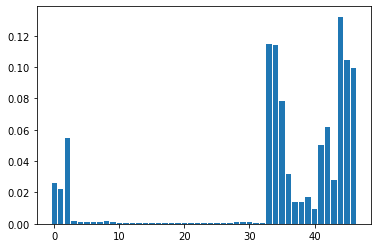

In [5]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    if v > 0.005:
        print(i,v,X_train.columns.tolist()[i])
    
plt.bar([x for x in range(len(importance))], importance)

### Parameters:

- n_estimators=100
- criterion='mse'
- max_depth=None
- min_samples_split=2
- min_samples_leaf=1
- min_weight_fraction_leaf=0.0
- max_features='auto'
- max_leaf_nodes=None
- min_impurity_decrease=0.0
- min_impurity_split=None
- bootstrap=True
- oob_score=False
- n_jobs=None
- random_state=None
- verbose=0
- warm_start=False
- ccp_alpha=0.0
- max_samples=None

In [ ]:
def bascktesting_random_forest(db, año, mes, rolling_window, days_start):
    fecha = datetime(año, mes, 1)
    fecha_str = str(año) + '-' + str(mes) + '-' + str(1)
    
    db = db.dropna()
    array_real, array_pred, array_date = np.zeros(len(db.loc[fecha_str:])), np.zeros(len(db.loc[fecha_str:])), []

    # En caso de que haya rolling window
    if rolling_window == True:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            print(day)
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_start_train = fecha_end_train - relativedelta(days = days_start)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            fecha_start_train = str(fecha_start_train.year) + "-" + str(fecha_start_train.month) + "-" + str(fecha_start_train.day)
            db_aux = db.loc[fecha_start_train:fecha_end_train]
            
            # Dataframe de Entrenamiento
            X_train = db_aux
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)

            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)

            # Entrenamos el modelo
            model = RandomForestRegressor(n_estimators = 150,
                              criterion = "mae",
                              max_depth = None,
                              max_features = X_train.shape[1]- 1,
                              n_jobs = -1,
                              warm_start = False,
                              random_state = 123).fit(X_train,y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
        
    # En caso de que no haya rolling window, siempre cogemos todo el dataframe disponible
    else:
        for day in range(int(len(db.loc[fecha_str:]) / 24)):
            print(day)
            fecha_end_train = fecha + relativedelta(days = day)
            fecha_end_train = str(fecha_end_train.year) + "-" + str(fecha_end_train.month) + "-" + str(fecha_end_train.day)
            db_aux = db.loc[:fecha_end_train]

            # Dataframe de Entrenamiento
            X_train = db_aux
            y_train = X_train.pop('Spot_electricidad')
            
            # Dataframe de Test
            X_test = X_train.loc[fecha_end_train]
            y_test = y_train.pop(fecha_end_train)
            
            # Quitamos al dataframe de train, el dataframe de test
            X_train = X_train.drop(index = X_train.iloc[-24:].index)
            
            # Entrenamos el modelo
            model = RandomForestRegressor(n_estimators = 100,
                              criterion = "mae",
                              max_depth = None,
                              max_features = X_train.shape[1] - 1,
                              n_jobs = -1,
                              random_state = 123).fit(X_train,y_train)
            
            # Realizamos las predicciones
            pred = model.predict(X_test)
            date = X_test.index

            array_date.append(date)
            array_pred[day*24:day*24 + 24] = pred
            array_real[day*24:day*24 + 24] = y_test
            
    array_date = [item for sublist in array_date for item in sublist]
    return array_pred, array_real, array_date

pred, real, dates = bascktesting_random_forest(db.loc["2019":], 2021, 1, rolling_window = True, days_start = 60)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


### Calculo de las metricas

In [36]:
resultados = pd.DataFrame({"Pred":pred, "Real":real}, index = dates)
resultados["Pred"][resultados.loc[:, "Pred"] < 0] = 0

rf, rf_metricas_mensuales, met = calculo_metricas(resultados)

     MAE  MAE (median)   MAPE  WMAPE   RMSE  % Trend
0  10.36          6.18  71.16   9.26  16.95     83.0


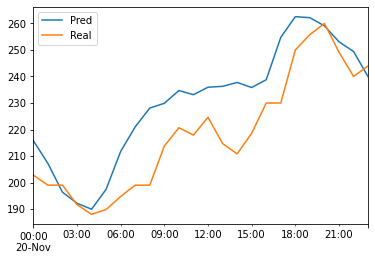

In [37]:
rf[["Pred", "Real"]].loc["2021-11-20"].plot()

### Optimizacion Bayesiana